In [43]:
import numpy as np
import matplotlib.pyplot as plt

In [44]:

class RandomWalk:
    def __init__(self, num_states=5):
        self.num_states = num_states
        self.state = num_states // 2  # Start at the center state

    def step(self, action):
        """Takes an action (-1: left, +1: right)"""
        self.state += action
        if self.state < 0:
            return -1, 0  # Terminal state with zero reward
        elif self.state >= self.num_states:
            return 1, 1  # Terminal state with reward 1
        return self.state, 0  # Non-terminal state with zero reward

    def reset(self):
        self.state = self.num_states // 2
        return self.state

In [45]:
def off_policy_learning(env, policy, behavior_policy, alpha=0.1, gamma=1.0, episodes=500, n=3, use_control_variate=True, runs=10):
    avg_MSEs = np.zeros(episodes)

    for _ in range(runs):
        V = np.zeros(env.num_states)
        MSEs = []
        # True value estimates for comparison
        target_V = np.linspace(0, 1, env.num_states)

        for _ in range(episodes):
            states, rewards, actions, rhos = [], [], [], []
            state = env.reset()
            while True:
                action = np.random.choice(
                    [-1, 1], p=[behavior_policy[state], 1 - behavior_policy[state]])
                next_state, reward = env.step(action)

                states.append(state)
                rewards.append(reward)
                actions.append(action)
                rhos.append(policy[state] / behavior_policy[state])

                if next_state in [-1, env.num_states]:
                    break
                state = next_state

            G = 0
            for t in reversed(range(len(states))):
                G = rewards[t] + gamma * G
                rho = rhos[t]

                if use_control_variate:
                    target = rho * (G - V[states[t]]) + \
                        (1 - rho) * V[states[t]]
                else:
                    target = rho * (G - V[states[t]])

                V[states[t]] += alpha * target

            MSEs.append(np.mean((V - target_V) ** 2))

        avg_MSEs += np.array(MSEs)

    return avg_MSEs / runs

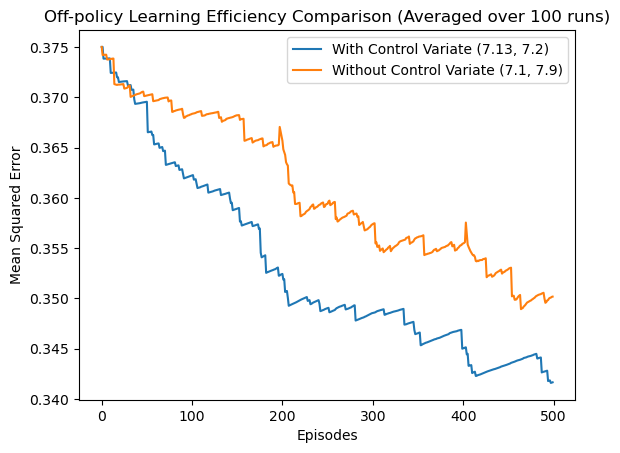

In [46]:
# Define environment
env = RandomWalk()
num_states = env.num_states

# Define policies
policy = np.ones(num_states) * 0.5  # Target policy (random)
behavior_policy = np.ones(num_states) * 0.9  # Behavior policy (biased)

# Run both learning algorithms over multiple runs
runs = 100
mse_control = off_policy_learning(
    env, policy, behavior_policy, use_control_variate=True, runs=runs)
mse_no_control = off_policy_learning(
    env, policy, behavior_policy, use_control_variate=False, runs=runs)

# Plot results
plt.plot(mse_control, label='With Control Variate (7.13, 7.2)')
plt.plot(mse_no_control, label='Without Control Variate (7.1, 7.9)')
plt.xlabel("Episodes")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title(
    "Off-policy Learning Efficiency Comparison (Averaged over {} runs)".format(runs))
plt.show()

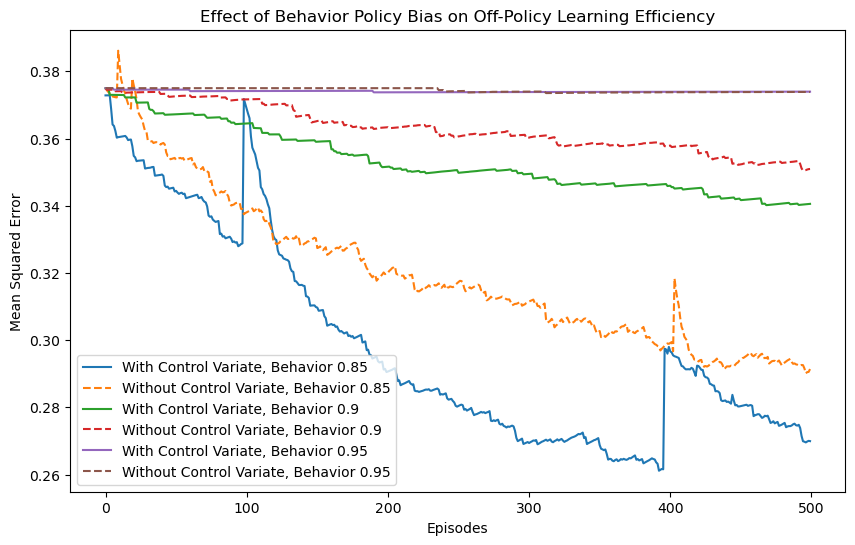

In [49]:
# Define different behavior policies to test
behavior_policies = [0.85, 0.9, 0.95]

# Store results for analysis
results = {}

for bp in behavior_policies:
    behavior_policy = np.ones(num_states) * bp  # Vary bias
    mse_control = off_policy_learning(
        env, policy, behavior_policy, use_control_variate=True, runs=runs)
    mse_no_control = off_policy_learning(
        env, policy, behavior_policy, use_control_variate=False, runs=runs)

    results[bp] = (mse_control, mse_no_control)

# Plot results for different behavior policies
plt.figure(figsize=(10, 6))
for bp, (mse_control, mse_no_control) in results.items():
    plt.plot(mse_control, label=f'With Control Variate, Behavior {bp}')
    plt.plot(mse_no_control,
             label=f'Without Control Variate, Behavior {bp}', linestyle='dashed')

plt.xlabel("Episodes")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("Effect of Behavior Policy Bias on Off-Policy Learning Efficiency")
plt.show()